<a href="https://colab.research.google.com/github/Eversco/ECE57000-DDPM/blob/main/DDPM_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Denoising Diffusion Probabilistic Models (DDPM) on CIFAR-10**

This notebook implements a DDPM for CIFAR-10. The notebook is organized into sections:
1. Configuration and Hyperparameters
2. Dataset Preparation
3. Model Definitions (U-Net and Noise Scheduler)
4. Training Loop
5. Sampling (Inference) Loop
6. Calculate Frechet Inception Distance (FID) Score

# 1. Configuration and Hyperparameters

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.4 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch_fid import fid_score

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Diffusion hyperparameters
NUM_TIMESTEPS = 1000
BETA_START = 1e-4
BETA_END = 0.02

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 2e-4

# Model parameters
IN_CHANNELS = 3
BASE_CHANNELS = 64
TIME_EMB_DIM = 128

im_channels = 3  # Example: For CIFAR-10
im_size = 32     # Example: For CIFAR-10
num_timesteps = 1000

# Initialize a list to store the training losses for each epoch.
training_losses = []

# Paths
DATA_ROOT = 'cifar10_data'

# 2. Dataset Preparation
**Please enter allow when the browser asks for permission to mount onto your drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_path = './gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/models'
sample_path = './gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/samples'
generated_image_path = './gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/generated_images'
real_image_path = './gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/images'

# Check if the folder exists and create it if it doesn't
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

ensure_directory_exists(model_path)
ensure_directory_exists(sample_path)
ensure_directory_exists(generated_image_path)
ensure_directory_exists(real_image_path)

Mounted at /content/gdrive


In [ ]:
# ---- CIFAR-10 Dataset Definition ----
class Cifar10Dataset(Dataset):
    """
    A simple dataset class using torchvision's CIFAR-10 dataset.
    """
    def __init__(self, split, root='cifar10_data', transform=None):
        """
        Initializes the dataset.
        :param split: 'train' or 'test' to load the respective dataset.
        :param root: root folder where CIFAR-10 data will be stored.
        :param transform: Optional transform to apply to the images.
        """
        self.split = split
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transform

        self.dataset = torchvision.datasets.CIFAR10(
            root=root,
            train=(split == 'train'),
            transform=self.transform,
            download=True
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

# Quick test
dataset = Cifar10Dataset(split='train', root=DATA_ROOT)
print(f"Number of training samples: {len(dataset)}")

100%|██████████| 170M/170M [00:32<00:00, 5.22MB/s]


Number of training samples: 50000


# 3. Model Definitions (U-Net and Noise Scheduler)

In [ ]:
# ---- Helper: Time Embedding Function ----
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: Tensor of shape (B,)
    :param embedding_dim: Dimensionality of the embedding.
    :return: Tensor of shape (B, embedding_dim)
    """
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

In [ ]:
# ---- Residual Block with Time Conditioning ----
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        # Use in_channels (actual input channels) for the first normalization.
        self.norm1 = nn.GroupNorm(num_groups=32, num_channels=in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=32, num_channels=out_channels)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
        self.time_emb = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time_emb(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return h + self.shortcut(x)


In [ ]:
# ---- Downsample and Upsample Blocks ----
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels=None):  # Add out_channels with a default value
        super(Downsample, self).__init__()
        # If out_channels is not provided, use in_channels (like before)
        out_channels = out_channels if out_channels is not None else in_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels=None):  # Add out_channels with a default value
        super(Upsample, self).__init__()
        # If out_channels is not provided, use in_channels (like before)
        out_channels = out_channels if out_channels is not None else in_channels
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

In [ ]:
# ---- Complete U-Net Architecture ----
class UNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, time_emb_dim=128):
        """
        A U-Net architecture for DDPM on 32x32 images with proper channel handling.
        Encoder downsamples and stores skip connections; decoder upsamples and concatenates them.
        """
        super(UNet, self).__init__()
        self.time_emb_dim = time_emb_dim

        # Time embedding network: embed timesteps into a vector.
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Initial convolution: project input to base_channels.
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)

        # --- Encoder (Downsampling) ---
        # Level 1: From 32x32, channels remain base_channels.
        self.res1 = ResidualBlock(base_channels, base_channels, time_emb_dim)
        # Save skip connection from level 1.
        self.down1 = Downsample(base_channels, base_channels * 2)  # 32 -> 16, channels: 64 -> 128

        # Level 2: From 16x16.
        self.res2 = ResidualBlock(base_channels * 2, base_channels * 2, time_emb_dim)
        self.down2 = Downsample(base_channels * 2, base_channels * 4)  # 16 -> 8, channels: 128 -> 256

        # Bottleneck at 8x8.
        self.mid = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        # --- Decoder (Upsampling) ---
        # Level 2: Upsample from bottleneck.
        self.up2 = Upsample(base_channels * 4, base_channels * 2)  # 8 -> 16, output channels: 256 -> 128
        # When concatenating with skip from level 2 (which has base_channels*2 channels), input channels = 128+128=256.
        self.res_up2 = ResidualBlock(base_channels * 2 + base_channels * 2, base_channels * 2, time_emb_dim)

        # Level 1: Upsample from level 2.
        self.up1 = Upsample(base_channels * 2, base_channels)  # 16 -> 32, 128 -> 64
        # Concatenate with skip from level 1 (base_channels=64): input channels = 64+64 = 128.
        self.res_up1 = ResidualBlock(base_channels + base_channels, base_channels, time_emb_dim)

        # Final normalization and projection back to image space.
        self.norm_out = nn.GroupNorm(num_groups=8, num_channels=base_channels)
        self.conv_out = nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Compute time embedding.
        # Here, t is expected to be a tensor of shape (B,) with integer timesteps.
        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)

        # Encoder
        h0 = self.conv_in(x)            # (B, 64, 32, 32)
        h1 = self.res1(h0, t_emb)         # (B, 64, 32, 32); skip connection for level 1.
        h1_down = self.down1(h1)          # (B, 128, 16, 16)

        h2 = self.res2(h1_down, t_emb)    # (B, 128, 16, 16); skip connection for level 2.
        h2_down = self.down2(h2)          # (B, 256, 8, 8)

        # Bottleneck
        h_mid = self.mid(h2_down, t_emb)  # (B, 256, 8, 8)

        # Decoder
        h2_up = self.up2(h_mid)           # (B, 128, 16, 16)
        # Concatenate skip from level 2 (h2): (B, 128, 16, 16) -> total channels 128+128=256.
        h2_cat = torch.cat([h2_up, h2], dim=1)
        h2_up_res = self.res_up2(h2_cat, t_emb)  # (B, 128, 16, 16)

        h1_up = self.up1(h2_up_res)       # (B, 64, 32, 32)
        # Concatenate skip from level 1 (h1): (B, 64, 32, 32) -> total channels 64+64=128.
        h1_cat = torch.cat([h1_up, h1], dim=1)
        h1_up_res = self.res_up1(h1_cat, t_emb)  # (B, 64, 32, 32)

        h_out = F.silu(self.norm_out(h1_up_res))
        out = self.conv_out(h_out)
        return out

In [ ]:
class NoiseScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        """
        Initializes the noise scheduler.
        Computes betas, alphas, cumulative products and related terms for the forward and reverse processes.
        """
        self.num_timesteps = num_timesteps
        self.device = device

        # Linear beta schedule.
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1.0 - self.betas
        # Cumulative product: alpha_bar_t = prod_{s=1}^t alpha_s.
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)

    def forward_diffusion(self, x0, t):
        """
        Forward process: Given an original image x0 and a timestep t (tensor of indices of shape (B,)),
        returns a noisy version x_t and the noise that was added.

        x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * noise
        """
        noise = torch.randn_like(x0)
        # Gather per-sample coefficients.
        sqrt_alpha_bar_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
        return xt, noise

    def sample_previous(self, xt, t, model):
        """
        Reverse diffusion step:
        Given x_t at timestep t and a model that predicts the noise,
        compute x0_pred and then sample x_{t-1} from the approximate reverse process:

          x0_pred = (x_t - sqrt(1 - alpha_bar_t) * predicted_noise) / sqrt(alpha_bar_t)
          mu = 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * predicted_noise)
          sigma²_t = beta_t_tilde = (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t) * beta_t
          x_{t-1} = mu + sigma_t * z   (if t > 0), else x0_pred.

        :param xt: current noisy image (B, C, H, W)
        :param t: Tensor of shape (B,) containing current timesteps.
        :param model: the noise prediction model (e.g. U-Net).
        :return: (xt_prev, x0_pred)
        """
        # Predict noise from the current image.
        predicted_noise = model(xt, t)

        # Get necessary coefficients
        sqrt_alpha_bar_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        # Estimate x0 from xt and predicted noise.
        x0_pred = (xt - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t

        # For the reverse process, get alpha_t and beta_t.
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)

        # Compute posterior variance beta_t_tilde for each sample.
        # For each timestep t > 0:
        # beta_t_tilde = (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t) * beta_t.
        # For t==0, we set sigma=0.
        t_minus_one = (t - 1).clamp(min=0)
        alpha_bar_prev = self.alpha_cumprod[t_minus_one].view(-1, 1, 1, 1)
        beta_t_tilde = beta_t * (1 - alpha_bar_prev) / (1 - self.alpha_cumprod[t].view(-1, 1, 1, 1))
        sigma_t = torch.sqrt(beta_t_tilde)

        # Compute the predicted mean mu.
        # mu = 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * predicted_noise)
        one_over_sqrt_alpha_t = 1.0 / torch.sqrt(alpha_t)
        mu = one_over_sqrt_alpha_t * (xt - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise)

        # For t > 0, add noise; for t == 0, no noise is added.
        noise = torch.randn_like(xt)
        # Create a mask: if t != 0 then add noise, else no noise.
        mask = (t != 0).view(-1, 1, 1, 1).float()
        xt_prev = mu + mask * sigma_t * noise
        return xt_prev, x0_pred

# 4. Training Loops
Please switch your runtime type to **T4 GPU** before calling ***train()***.
(You can use V2-8 TPU as well. However, it will require a significantly longer time to process)

In [ ]:
# prompt: define train() that create the noise scheduler, create the dataset, instantiate the model, specify training parameters, run training (ignore labels, sample random noise, sample timestep, add noise to images according to timestep), and save model checkpoint to model_path

def train():
    """
    Train the DDPM U-Net model on the CIFAR-10 dataset.

    Steps:
      - Create the noise scheduler.
      - Create the CIFAR-10 training dataset and DataLoader.
      - Instantiate the U-Net model.
      - Set up the optimizer and MSE loss function.
      - For each batch:
           • Sample a random timestep.
           • Add noise to images using the forward diffusion process.
           • Predict the noise using the model.
           • Compute the MSE loss between predicted and actual noise.
           • Backpropagate and update the model.
      - Save the model checkpoint to model_path.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create the noise scheduler instance.
    scheduler = NoiseScheduler(num_timesteps=NUM_TIMESTEPS,
                                beta_start=1e-4, beta_end=0.02,
                                device=device)

    # Create the training dataset and DataLoader.
    train_dataset = Cifar10Dataset(split='train', root='cifar10_data')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    # Instantiate the U-Net model and move it to the selected device.
    model = UNet(in_channels=3, base_channels=BASE_CHANNELS, time_emb_dim=TIME_EMB_DIM).to(device)

    # Set up the optimizer and MSE loss function.
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    # Training loop.
    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=True, ncols=80):
            images = images.to(device)
            # Sample a random timestep for each image in the batch.
            t = torch.randint(0, scheduler.num_timesteps, (images.size(0),), device=device)
            # Generate the noisy image and obtain the noise used.
            xt, noise = scheduler.forward_diffusion(images, t)
            # Model predicts the noise from the noisy image.
            predicted_noise = model(xt, t)
            loss = loss_fn(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")

        # Save model checkpoint
        torch.save(model.state_dict(), os.path.join(model_path, f'ddpm_cifar10_epoch_{epoch + 1}.pth'))

    return training_losses  # Return the collected training losses

In [ ]:
# prompt: define sample(). Sample stepwise by going backward one timestep at a time. We save the x0 predictions every 100 steps and display them. Get prediction of noise. Use scheduler to get x0 and xt-1, Save and display x0 every 100 steps ( Save image and Convert to numpy array for displaying), and Display the images. then define infer by loading model and create the noise scheduler

def sample(model, scheduler, device, epoch_idx, num_samples=16, num_grid_rows=4):
    """
    Sample stepwise by going backward one timestep at a time.
    Saves and displays the generated images.
    """
    model.eval()
    # Start with pure Gaussian noise.
    x = torch.randn((num_samples, 3, 32, 32), device=device)
    images_to_show = []
    step_indexes = []

    # Iterate backward from T-1 down to 0.
    for t in reversed(range(scheduler.num_timesteps)):
        # Create a tensor of timesteps for the entire batch.
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        # Get one reverse diffusion step.
        x, x0_pred = scheduler.sample_previous(x, t_tensor, model)

        # Every 100 steps, save and display the predicted x0.
        if t % 100 == 0 or t == 0 or t == scheduler.num_timesteps - 1:
            # Clamp the prediction (if needed) and scale from [-1,1] to [0,1] for display.
            x0_disp = torch.clamp(x0_pred, -1, 1)
            x0_disp = (x0_disp + 1) / 2.0  # rescale
            grid = make_grid(x0_disp, nrow=num_grid_rows, padding=2)

            # Convert to numpy array for displaying
            grid_np = grid.cpu().numpy().transpose(1, 2, 0)
            images_to_show.append(grid_np)
            step_indexes.append(t)

            # Save image
            img = torchvision.transforms.ToPILImage()(grid)
            ensure_directory_exists(os.path.join(generated_image_path, f'epoch_{epoch_idx + 1}'))
            img.save(os.path.join(generated_image_path, f'epoch_{epoch_idx + 1}/x0_{t}.png'))
            img.close()

    # Display the images
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(20, 5))
    fig.suptitle(f'Epoch {epoch_idx + 1} Sample Images', fontsize=16)
    for ax, img, idx in zip(axes, images_to_show, step_indexes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Step {idx}', fontsize=10)
    plt.show()

    return x0_pred  # Return final prediction

def infer():
    """
    Inference wrapper:
      - Loads the trained model for each epoch.
      - Creates the noise scheduler.
      - Calls sample() to generate and display images for each epoch.
    """
    # Set device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    torch.cuda.empty_cache()  # Clear the cache before loading the model

    # Instantiate the model with the same parameters used in training.
    model = UNet(in_channels=3, base_channels=BASE_CHANNELS, time_emb_dim=TIME_EMB_DIM).to(device)

    # Create the noise scheduler.
    scheduler = NoiseScheduler(num_timesteps=NUM_TIMESTEPS, beta_start=BETA_START, beta_end=BETA_END, device=device)

    # Run the sampling process for each epoch
    for epoch_idx in range(NUM_EPOCHS):
        # Load the saved checkpoint for the current epoch
        checkpoint_path = os.path.join(model_path, f'ddpm_cifar10_epoch_{epoch_idx + 1}.pth')
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.eval()

        # Run the sampling process and display images for the current epoch
        final_x0 = sample(model, scheduler, device, epoch_idx=epoch_idx)

    return final_x0 # Return the images generated in the last epoch

In [ ]:
# Call the train() function to train the model and collect training losses.
training_losses = train()

Epoch 1/15: 100%|█████████████████████████████| 782/782 [02:17<00:00,  5.69it/s]


Epoch 1/15 - Loss: 0.0795


Epoch 2/15: 100%|█████████████████████████████| 782/782 [02:17<00:00,  5.69it/s]


Epoch 2/15 - Loss: 0.0456


Epoch 3/15: 100%|█████████████████████████████| 782/782 [02:21<00:00,  5.53it/s]


Epoch 3/15 - Loss: 0.0410


Epoch 4/15: 100%|█████████████████████████████| 782/782 [02:20<00:00,  5.56it/s]


Epoch 4/15 - Loss: 0.0389


Epoch 5/15: 100%|█████████████████████████████| 782/782 [02:18<00:00,  5.65it/s]


Epoch 5/15 - Loss: 0.0374


Epoch 6/15: 100%|█████████████████████████████| 782/782 [02:13<00:00,  5.87it/s]


Epoch 6/15 - Loss: 0.0364


Epoch 7/15: 100%|█████████████████████████████| 782/782 [02:14<00:00,  5.80it/s]


Epoch 7/15 - Loss: 0.0364


Epoch 8/15: 100%|█████████████████████████████| 782/782 [02:13<00:00,  5.87it/s]


Epoch 8/15 - Loss: 0.0358


Epoch 9/15: 100%|█████████████████████████████| 782/782 [02:13<00:00,  5.86it/s]


Epoch 9/15 - Loss: 0.0355


Epoch 10/15: 100%|████████████████████████████| 782/782 [02:17<00:00,  5.67it/s]


Epoch 10/15 - Loss: 0.0349


Epoch 11/15: 100%|████████████████████████████| 782/782 [02:16<00:00,  5.75it/s]


Epoch 11/15 - Loss: 0.0349


Epoch 12/15: 100%|████████████████████████████| 782/782 [02:19<00:00,  5.61it/s]


Epoch 12/15 - Loss: 0.0347


Epoch 13/15: 100%|████████████████████████████| 782/782 [02:15<00:00,  5.75it/s]


Epoch 13/15 - Loss: 0.0345


Epoch 14/15: 100%|████████████████████████████| 782/782 [02:15<00:00,  5.75it/s]


Epoch 14/15 - Loss: 0.0345


Epoch 15/15: 100%|████████████████████████████| 782/782 [02:11<00:00,  5.96it/s]


Epoch 15/15 - Loss: 0.0345


# 5. Sampling (Inference) Loop
Please switch your runtime type to **V2-8 GPU** before calling ***infer()***.

As T4 GPU would exceed the limit of memory CUDA offers, V2-8 TPU is more reliable for the perfomance.
If you wish to run the process faster with GPU, you can purchase Colab Premium.

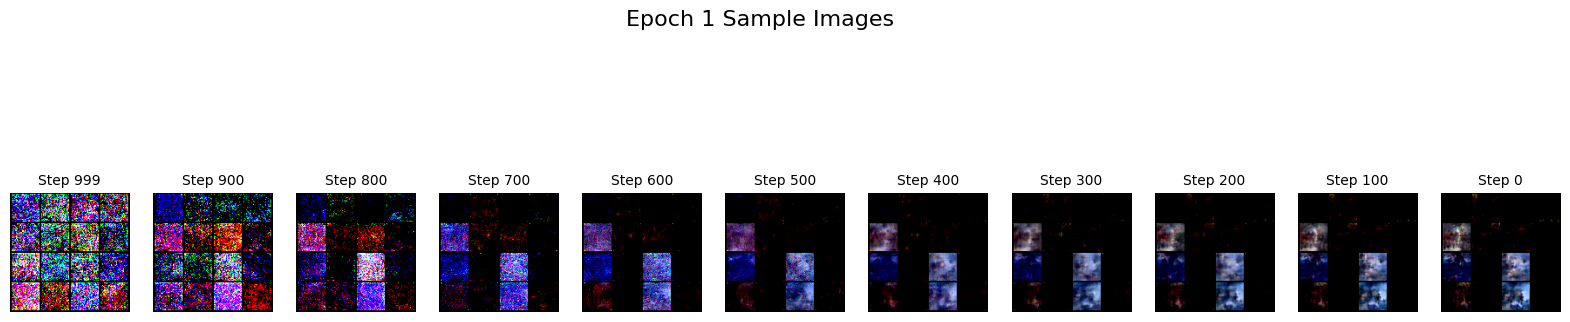

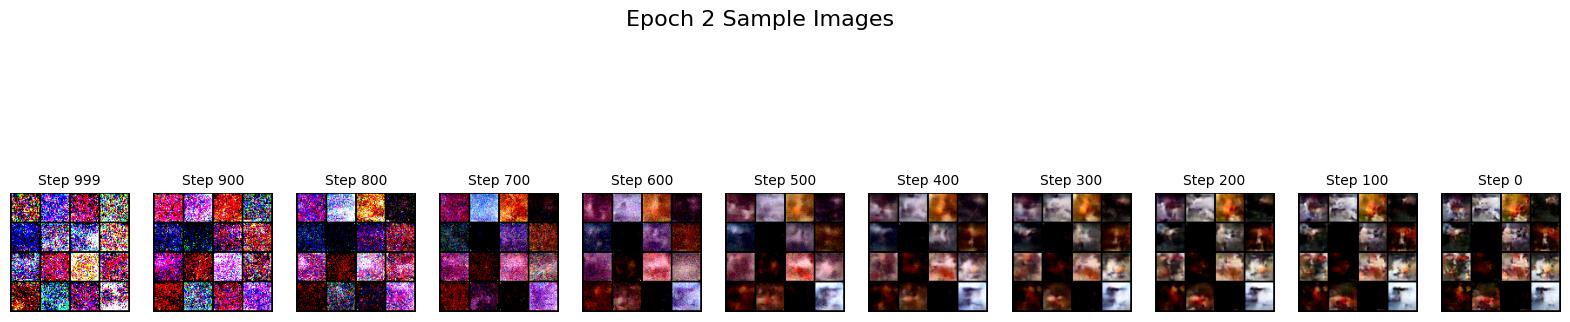

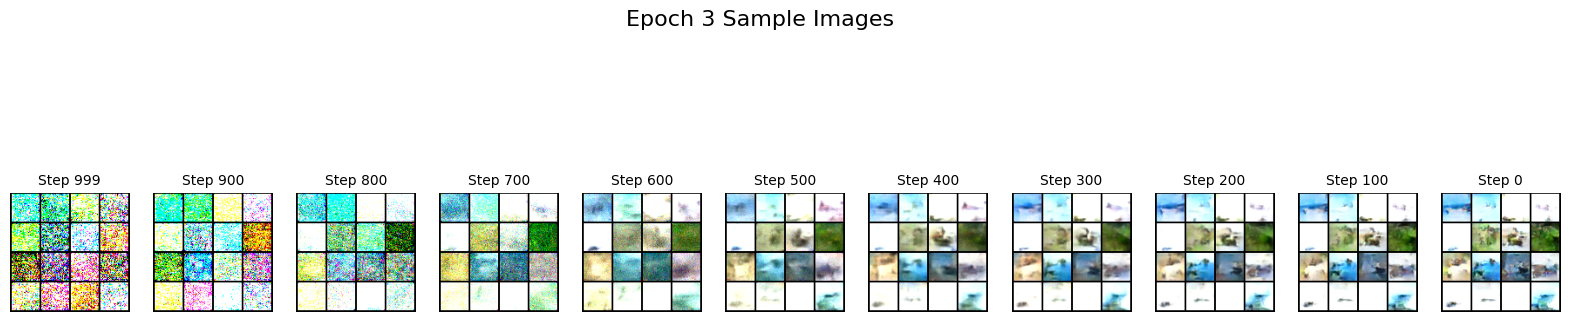

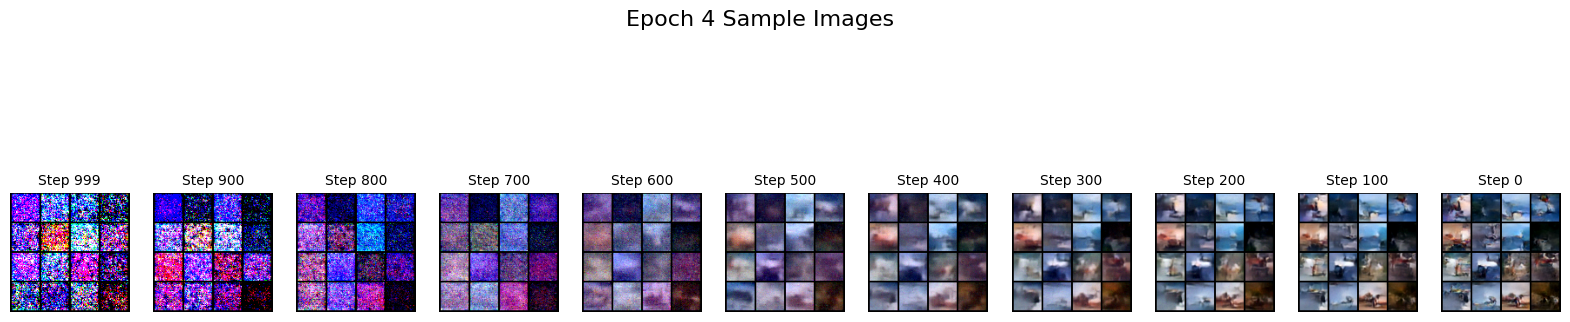

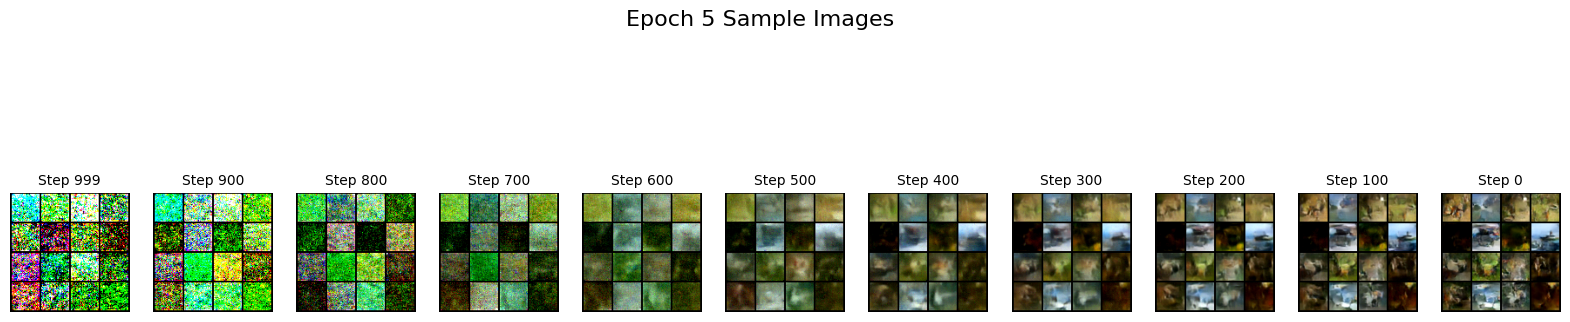

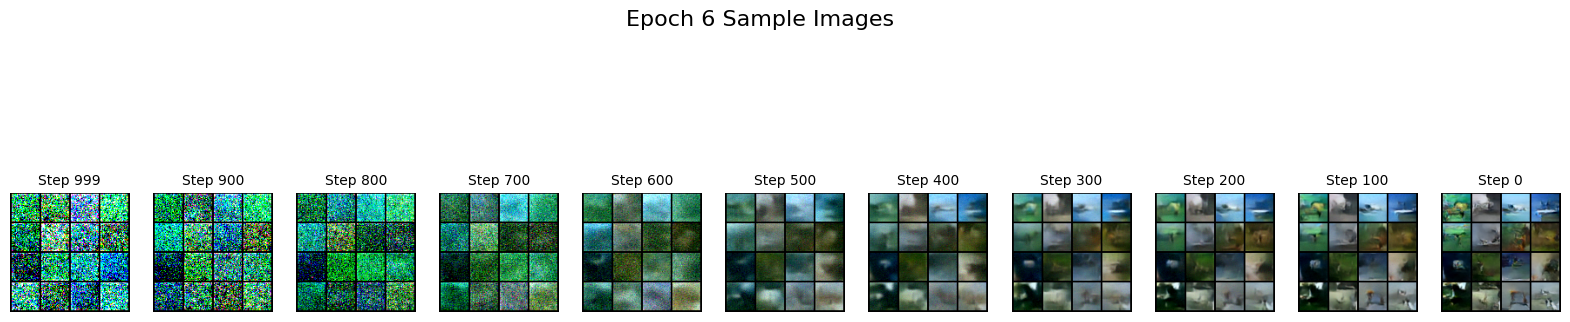

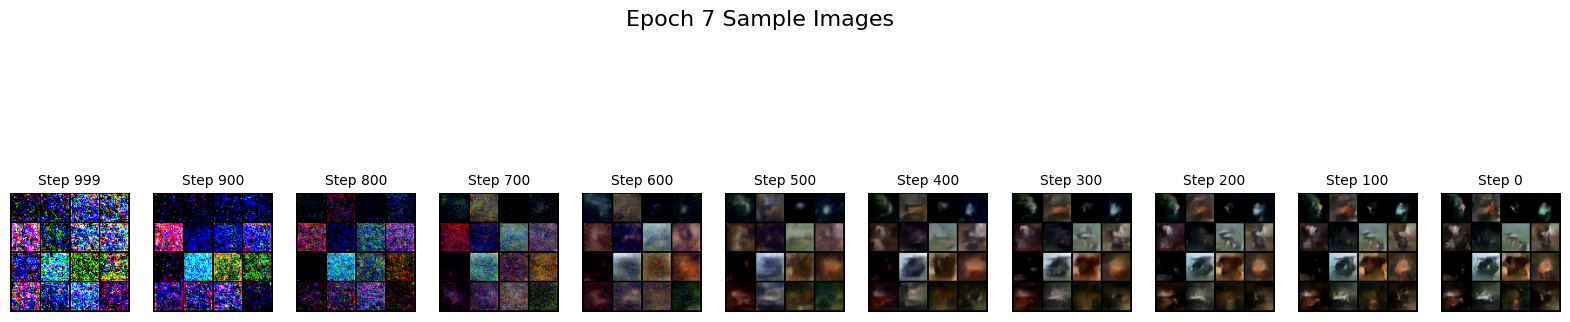

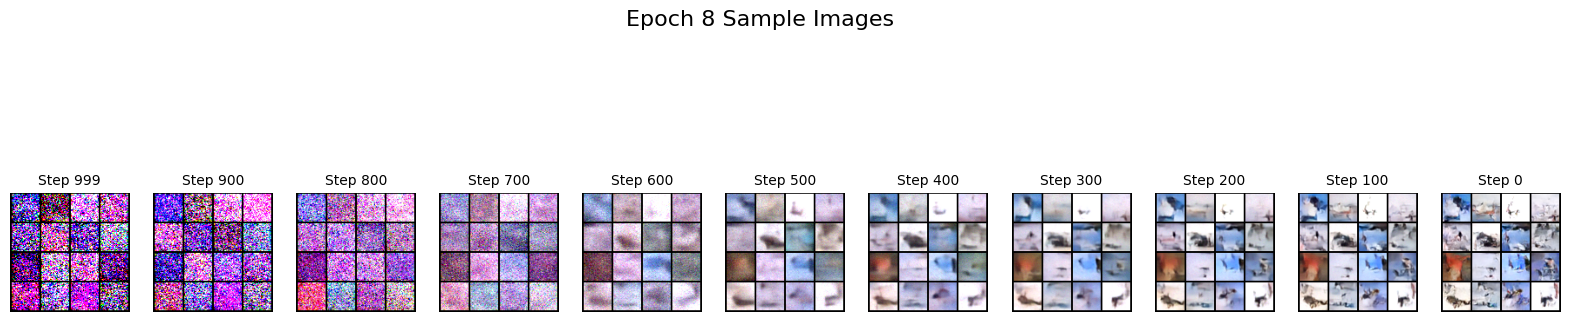

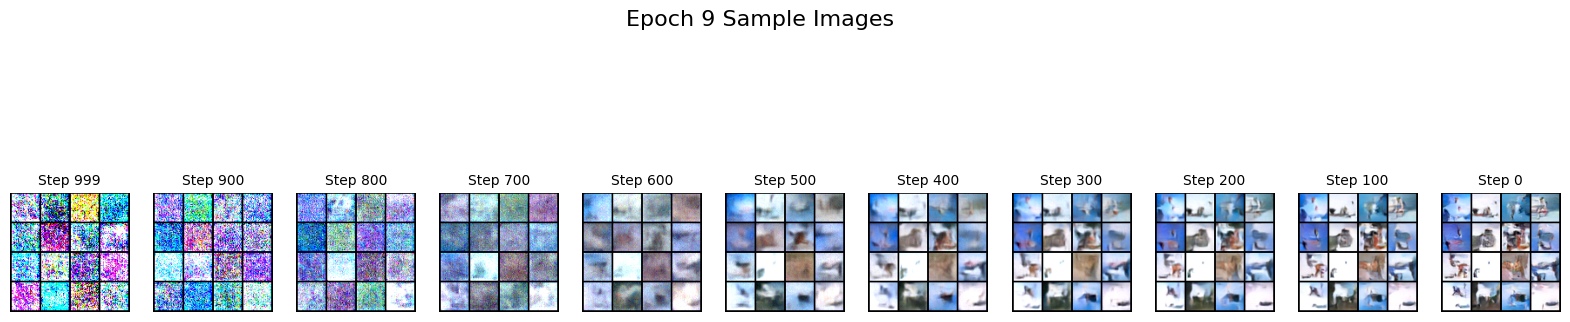

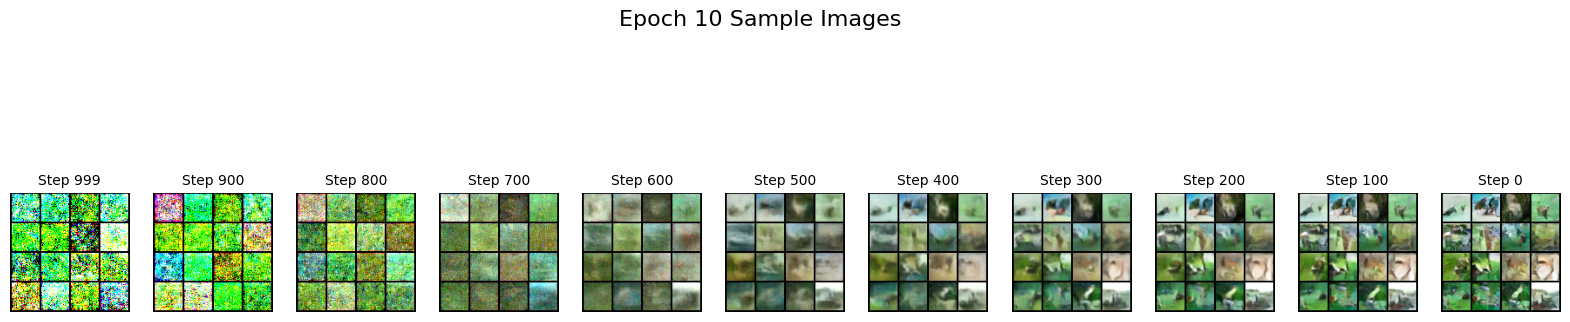

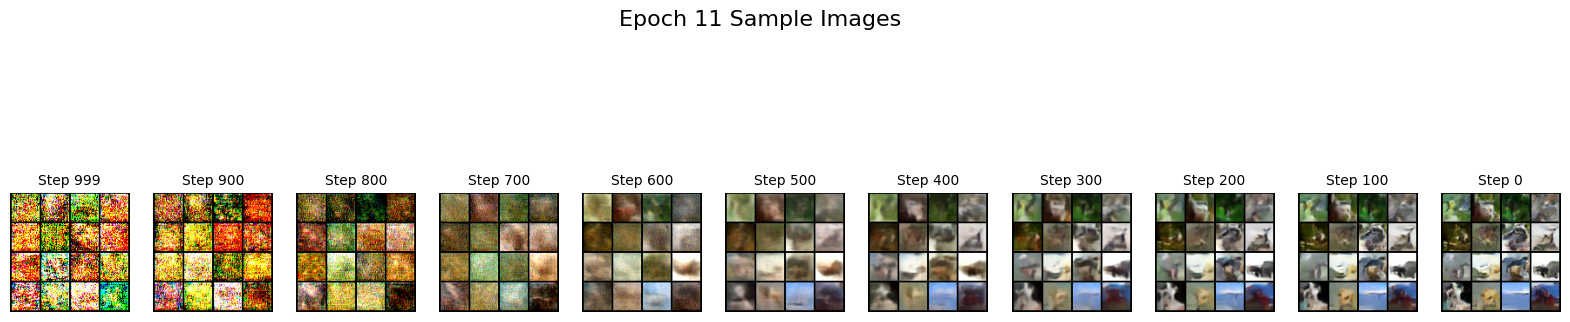

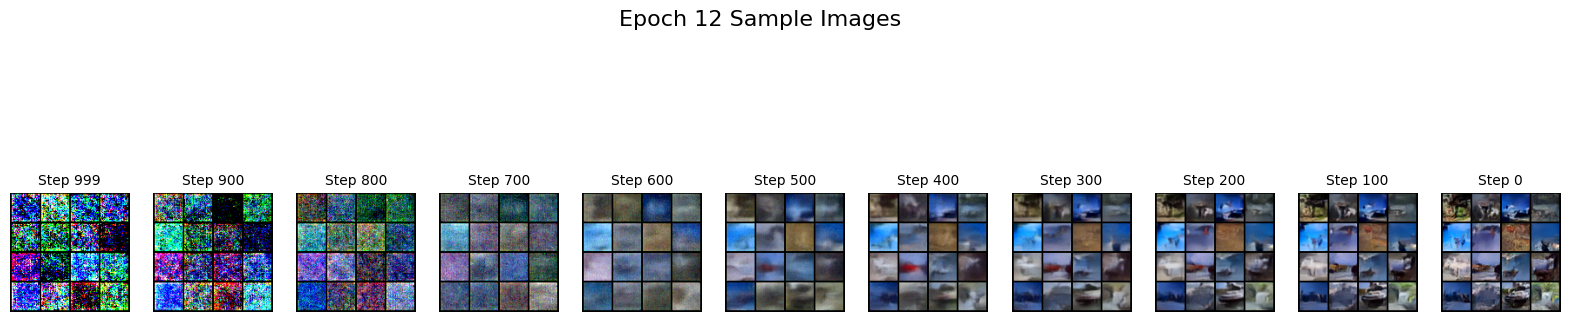

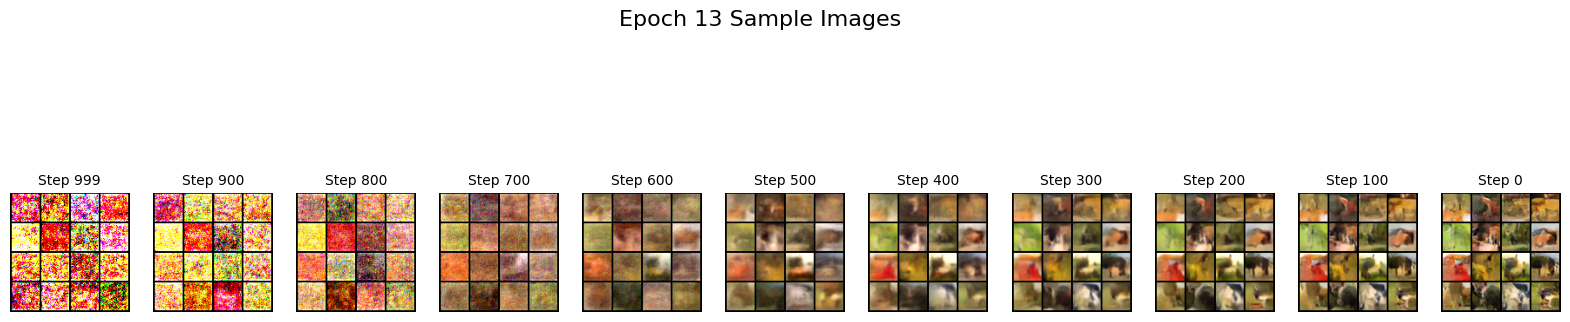

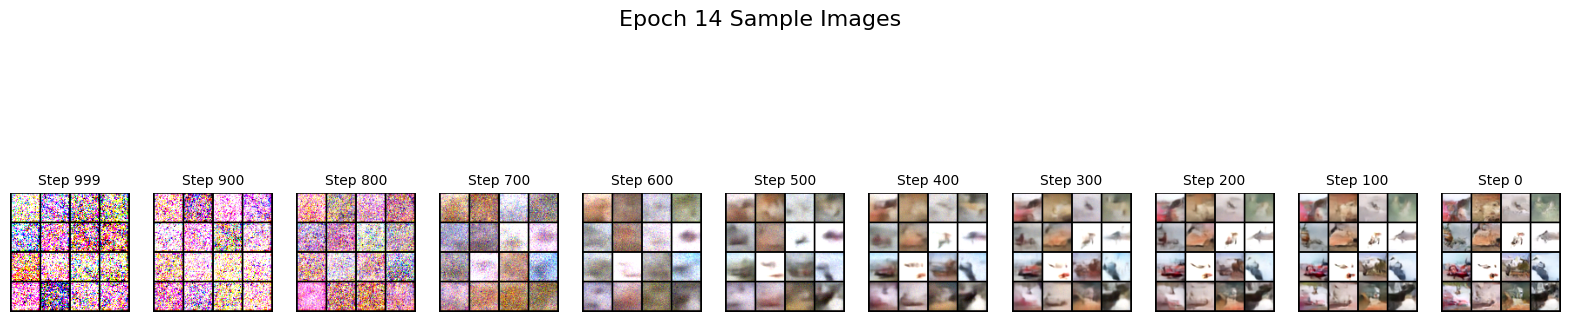

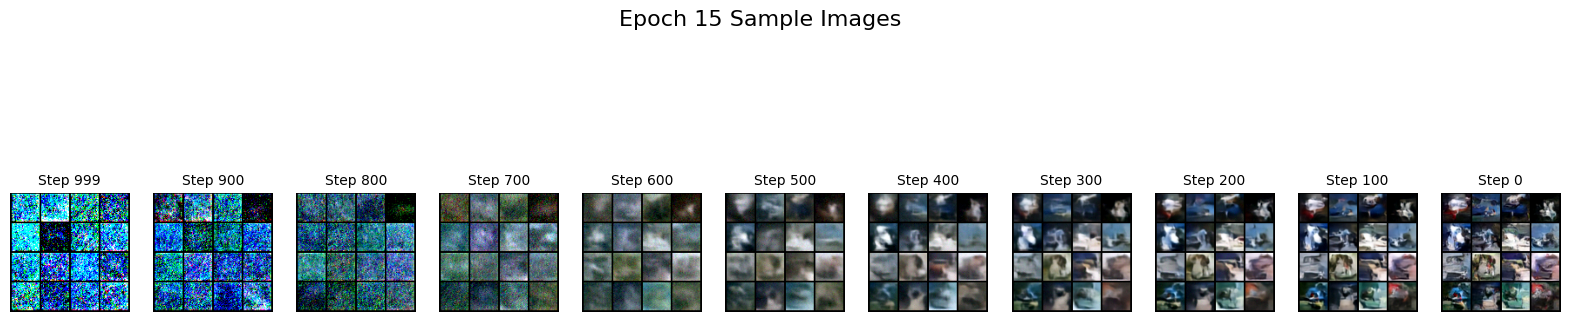

In [ ]:
generated_images = infer();

# 6. Results Visualization

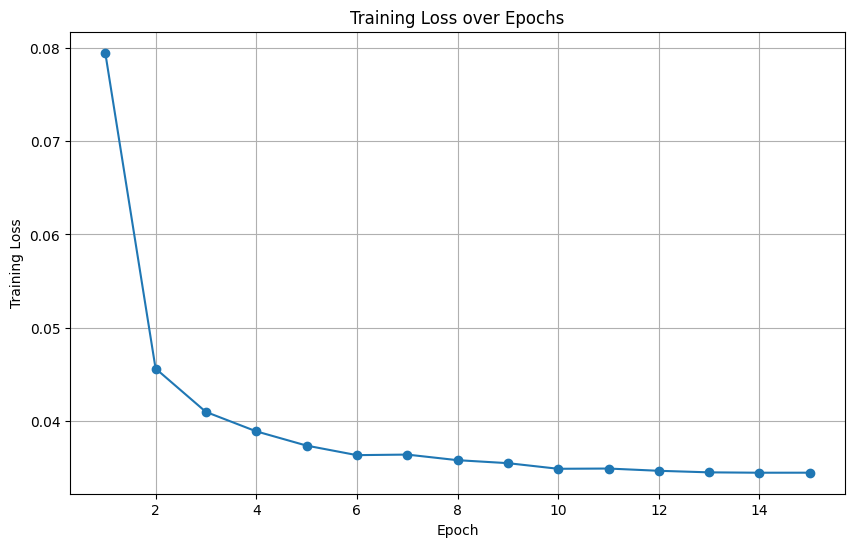

In [ ]:
# Create a list of epochs
epochs = list(range(1, len(training_losses) + 1))

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# 7. Calculate Frechet Inception Distance (FID) Score

In [ ]:
# Define number of FID images to generate
fid_samples = 5000  # adjust as needed

# Sampling function to save generated images for FID calculation
def save_generated_images(model, scheduler, fid_samples=fid_samples, output_dir=generated_image_path, batch_size=64):  # Add batch_size parameter
    model.eval()
    ensure_directory_exists(output_dir)
    num_batches = (fid_samples + batch_size - 1) // batch_size  # Calculate number of batches

    with torch.no_grad():
        for batch_idx in tqdm(range(num_batches), desc="Generating FID images", leave=True, ncols=80):
            # Generate a batch of noise samples
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, fid_samples)
            current_batch_size = end_idx - start_idx
            xt = torch.randn((current_batch_size, im_channels, im_size, im_size), device=device)

            # Stepwise reverse diffusion: from T-1 to 0
            for t in reversed(range(NUM_TIMESTEPS)):
                # Create a tensor of timesteps for the current batch
                t_tensor = torch.full((current_batch_size,), t, device=device, dtype=torch.long)

                noise_pred = model(xt, t_tensor)  # Predict noise for the batch
                xt, _ = scheduler.sample_previous(xt, t_tensor, model)  # Reverse diffusion step

            # Process the final predictions for the batch: clamp and rescale
            ims = torch.clamp(xt, -1., 1.).detach().cpu()
            ims = (ims + 1) / 2.0

            # Save each image in the batch
            for i, im in enumerate(ims):
                grid = make_grid(im.unsqueeze(0), nrow=1)  # Make grid for a single image
                img = torchvision.transforms.ToPILImage()(grid)
                img.save(os.path.join(output_dir, f'image_{start_idx + i}.png'))
                img.close()

    print(f"Generated images saved to {output_dir}")

In [ ]:
# Function to save real CIFAR-10 test images for FID calculation
def save_real_images(fid_samples=fid_samples, output_dir=real_image_path):
    ensure_directory_exists(output_dir)
    # Use same transform as in your dataset (assumed to output images in [-1, 1])
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    for idx, (image, _) in tqdm(enumerate(cifar10_test), total=fid_samples, desc="Saving real images", leave=True, ncols=80): # Progress bar for saving loop
        if idx >= fid_samples:
            break
        # Convert normalized tensor to [0,1] range
        ims = (image + 1) / 2.0
        grid = make_grid(ims, nrow=1)
        # Since image is a single tensor, we can directly convert it without making a grid.
        img = torchvision.transforms.ToPILImage()(ims)
        img.save(os.path.join(output_dir, f'image_{idx}.png'))
        img.close()
    print(f"Real images saved to {output_dir}")

In [ ]:
# Instantiate the noise scheduler and model, then load a trained checkpoint.
scheduler = NoiseScheduler(num_timesteps=NUM_TIMESTEPS, beta_start=BETA_START, beta_end=BETA_END, device=device)
model = UNet(in_channels=3, base_channels=BASE_CHANNELS, time_emb_dim=TIME_EMB_DIM).to(device)
# Load the model from the final epoch checkpoint (adjust epoch number as needed)

checkpoint_path = os.path.join(model_path, f'ddpm_cifar10_epoch_{NUM_EPOCHS}.pth')
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Save generated and real images.
save_generated_images(model, scheduler, fid_samples=fid_samples, output_dir=generated_image_path)
save_real_images(fid_samples=fid_samples, output_dir=real_image_path)

# Calculate FID score between generated images and real images.
fid_value = fid_score.calculate_fid_given_paths([generated_image_path, real_image_path],
                                                batch_size=50, device=device, dims=2048)
print(f'FID score: {fid_value}')

Generating FID images: 100%|█████████████████| 47/47 [2:06:41<00:00, 161.74s/it]


Generated images saved to ./gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/generated_images


100%|██████████| 170M/170M [00:01<00:00, 90.3MB/s]
Saving real images: 100%|███████████████████| 3000/3000 [11:41<00:00,  4.28it/s]


Real images saved to ./gdrive/MyDrive/Colab Notebooks/ECE570/DDPM_project/ddpm_cifar10/images


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 311MB/s]
100%|██████████| 60/60 [01:34<00:00,  1.58s/it]


FID score: 91.6096603017645
